In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import pandas as pd
import numpy as np
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 

/home/ubuntu/miniconda3/envs/handbook/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ds = load_from_disk("datasets/value_at_index/v0.1")

In [5]:
ds

Dataset({
    features: ['array', 'query', 'target', 'few_shots', 'query_array_length', 'num_few_shots', 'task_prompt'],
    num_rows: 48000
})

In [6]:
def parse_output_to_df(output_paths):
    eval_data = {}
    for model_name, p in output_paths.items():
        output = torch.load(p)
        eval_data[model_name] = output['all_preds']

    columns=["data_id", *eval_data.keys(), 'target', 'target_index', 'query_array_length', 'num_few_shots']
    df = pd.DataFrame(columns=columns, data=zip(np.arange(len(ds)), *[eval_data[m] for m in eval_data.keys()], ds['target'], ds['query'], ds['query_array_length'], ds['num_few_shots']))
    df.head(10)

    is_correct_df = df.copy()
    for model_name in eval_data.keys():
        is_correct_df[model_name] = (is_correct_df[model_name].apply(lambda x: x.strip()) == is_correct_df['target'].apply(lambda x: str(x)))
    return df, is_correct_df

In [11]:
output_paths = {
    # 'gpt2': 'outputs_v0_0/gpt2-value_at_index_v0_0.pkl',
    # 'gpt2-xl': 'outputs_v0_0/gpt2-xl.pkl',
    # 'stablelm-2-1.6b': 'outputs_v0_0/stablelm-2-1_6b.pkl',
    # 'phi-1.5': 'outputs_v0_0/phi-1_5.pkl',
    # 'phi-2': 'outputs_v0_0/phi-2.pkl',
    # 'gpt-j-6b': 'outputs_v0_0/gpt-j-6b.pkl',
    # 'Mistral-7b-v0.1': 'outputs_v0_0/Mistral-7B-v0.1.pkl',
    # 'zephyr-7b-beta': 'outputs_v0_0/zephyr-7b-beta.pkl',
    # 'Llama-2-7b': 'outputs_v0_0/Llama-2-7b-hf.pkl',
    # 'Llama-2-13b': 'outputs_v0_0/Llama-2-13b-hf.pkl',

    'phi-2': 'outputs/index-op-v0.1/phi-2.pkl',
    'gpt2': 'outputs/index-op-v0.1/gpt2.pkl'
}

df, is_correct_df = parse_output_to_df(output_paths)

# output_paths = {
#     # 'gpt2': 'outputs_v0_0_wo_task_description/gpt2.pkl',
#     # 'gpt2-xl': 'outputs_v0_0_wo_task_description/gpt2-xl.pkl',
#     # 'gpt-j-6b': 'outputs_v0_0_wo_task_description/gpt-j-6b.pkl',
#     # 'Mistral-7b-v0.1': 'outputs_v0_0_wo_task_description/Mistral-7B-v0.1.pkl',
#     # 'Llama-2-7b': 'outputs_v0_0_wo_task_description/Llama-2-7b-hf.pkl',
#     # 'Llama-2-13b': 'outputs_v0_0_wo_task_description/Llama-2-13b-hf.pkl',
#     'phi-2': 'outputs_v0_0_wo_task_description/phi-2.pkl',
# }
# wotd_df, is_correct_df_wo_task_description = parse_output_to_df(output_paths)

In [12]:
# is_correct_df = is_correct_df[(is_correct_df['num_few_shots'] == 0) & (is_correct_df['query_array_length'] == 10)]  
# is_correct_df_wo_task_description = is_correct_df_wo_task_description[is_correct_df_wo_task_description['num_few_shots'] == 1]

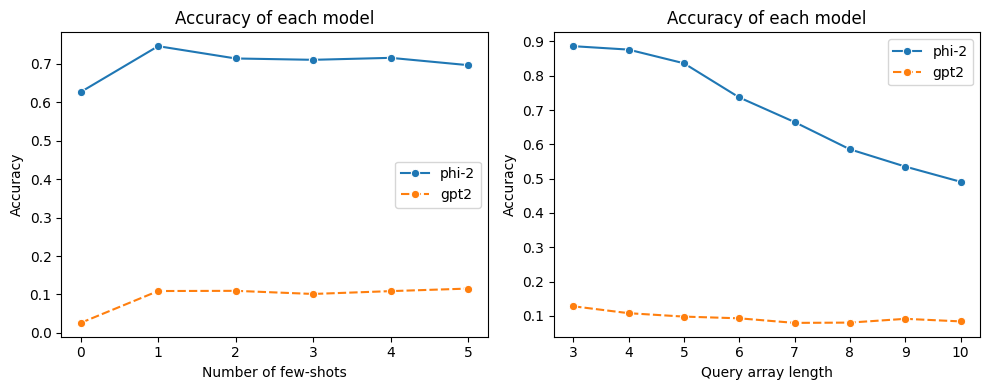

In [13]:
# Line plot, showing accuracy of each model
# There are 2 axes, one group by num_few_shots, one group by query_array_length
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
# xrange = min(is_correct_df['num_few_shots'].unique()), max(is_correct_df['num_few_shots'].unique())
# ax.hlines(0.1, *xrange, linestyles='dashed', colors='black', label='Random guess')
sns.lineplot(data=is_correct_df.groupby(['num_few_shots'])[[*output_paths.keys()]].mean(), ax=ax, marker='o')
# sns.lineplot(data=is_correct_df_wo_task_description.groupby(['num_few_shots'])[[*output_paths.keys()]].mean(), ax=ax, marker='^')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of few-shots")
ax.set_title("Accuracy of each model")


ax = axes[1]
# xrange = min(is_correct_df['query_array_length'].unique()), max(is_correct_df['query_array_length'].unique())
# ax.hlines(0.1, *xrange, linestyles='dashed', colors='black', label='Random guess')
sns.lineplot(data=is_correct_df.groupby(['query_array_length'])[[*output_paths.keys()]].mean(), ax=ax, marker='o')
# sns.lineplot(data=is_correct_df_wo_task_description.groupby(['query_array_length'])[[*output_paths.keys()]].mean(), ax=ax, marker='^')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Query array length")
ax.set_title("Accuracy of each model")

plt.tight_layout()
plt.show()

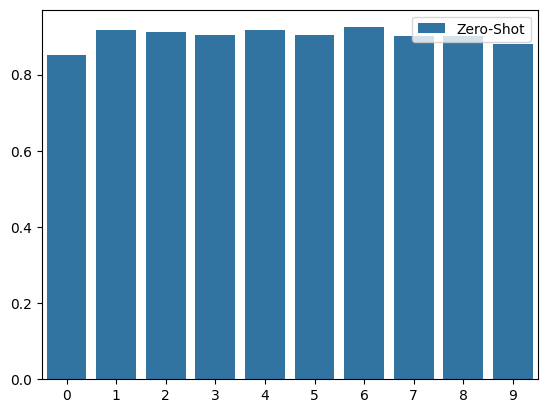

In [55]:
array_length = 10
ds_hist = np.histogram(is_correct_df[is_correct_df['query_array_length'] == array_length]['target_index'], bins=array_length)
with_des_error_target_index = is_correct_df[(is_correct_df['gpt2'] == False) & (is_correct_df['query_array_length'] == array_length)]['target_index']
with_des_error_hist = np.histogram(with_des_error_target_index, bins=array_length)

sns.barplot(x=np.arange(array_length), y=with_des_error_hist[0] / ds_hist[0], label='Zero-Shot')

# wtthout_des_error_target_index = is_correct_df_wo_task_description[(is_correct_df_wo_task_description['phi-2'] == False) & (is_correct_df_wo_task_description['query_array_length'] == array_length)]['target_index']
# wtthout_des_error_hist = np.histogram(wtthout_des_error_target_index, bins=array_length)
# sns.barplot(x=np.arange(array_length), y=(wtthout_des_error_hist[0] - with_des_error_hist[0]) / ds_hist[0], label='With task description')



plt.legend()

In [22]:
is_correct_df.groupby(['num_few_shots', 'query_array_length'])[[*eval_data.keys()]].mean()

NameError: name 'eval_data' is not defined

In [21]:
acc_df = pd.DataFrame(data=(correct_arr / count_arr)*100)
acc_df = acc_df.rename_axis('num-shot')
acc_df = acc_df.rename_axis('array length', axis = 'columns') 
acc_df_style = acc_df.style
acc_df_style.background_gradient(cmap='Blues', vmin=0, vmax=100)
acc_df_style.format('{:.0f}')

NameError: name 'correct_arr' is not defined